# CCL matter power spectra calculations

In this example, we will calculate the matter power spectrum using different options for the transfer function (CAMB, CLASS, etc.), different options for the matter power spectrum (emulator, with baryons) and different cosmologies, including parametrized Modified Gravity.

Note that you will need CAMB and CLASS installed in your system. You can check our installation instructions for further details: https://ccl.readthedocs.io/en/v2.0.0/source/installation.html

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import math
%matplotlib inline

We begin by defining a set of cosmological parameters, as usual:

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, 
                      transfer_function='boltzmann_class')

Note that we have explicitly defined how transfer functions should be calculated for the linear matter power spectrum, by using the `transfer_function` keyword argument. The types of transfer function are listed [here](https://ccl.readthedocs.io/en/latest/source/notation_and_other_cosmological_conventions.html#supported-models-for-the-power-spectrum-mass-function-etc).

The default is `boltzmann_camb`, which uses a full transfer function calculation from the CAMB Boltzmann code. This is one of the most accurate options at the level of linear pertubation theory, but will be less accurate at non-linear scales.

If we were less interested in precision but wanted to improve speed, we could have chosen the `eisenstein_hu` option instead.

Likewise, the `Cosmology()` object constructor also has a `matter_power_spectrum` argument that can be changed. There is no need to do this for now, however.

### NB: How CCL caches results
Now, we can calculate the linear and non-linear matter power spectra as a function of wavenumber. Before we do that though, let's just perform a quick test to see how CCL caches the results of calculations:

In [3]:
print(cosmo.has_linear_power)
print(cosmo.has_sigma)

False
False


Both of these status indicators are `False`, showing that CCL hasn't yet computer power spectra (transfer functions) or sigma(R); the cache is currently empty. When we calculate the power spectrum, though, the result will be stored (and splined) for future use.

## Calculate the matter power spectrum

Now, let's calculate the power spectra:

In [4]:
kmin, kmax, nk = 1e-4, 1e1, 128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
a = 1. # Scale factor a z=0

In [7]:
pk_lin = ccl.linear_matter_power(cosmo, k, a)
pk_nl = ccl.nonlin_matter_power(cosmo, k, a)

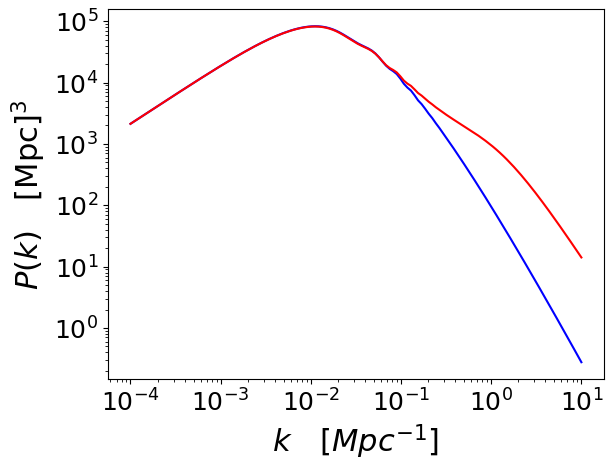

In [8]:
plt.plot(k, pk_lin, 'b-')
plt.plot(k, pk_nl, 'r-')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize = 22)
plt.ylabel('$P(k)\quad[{\\rm Mpc}]^3$', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

We can see that the cache has now been populated:

In [9]:
print(cosmo.has_linear_power)

True


Subsequent calls to `linear_matter_power()` will be faster for the same cosmology (i.e. the same `Cosmology` object).

### Power spectrum normalisation, sigma8
We can also calculate the normalisation of the power spectrum, sigma8. Note that this parameter is currently undefined:

In [10]:
print(cosmo['sigma8'])

nan


If we now call the `sigma8()` function, this value should be populated:

In [11]:
print(ccl.sigma8(cosmo))
print(cosmo['sigma8'])

0.8402228551481183
0.8402228551481183


### Adding the impact of baryons
The power spectrum can also be modified to include the impact of baryons. The overall effect will be to include a scale-dependence which will suppress the power spectrum at scales smaller than a few Mpc/h. Here is an example:

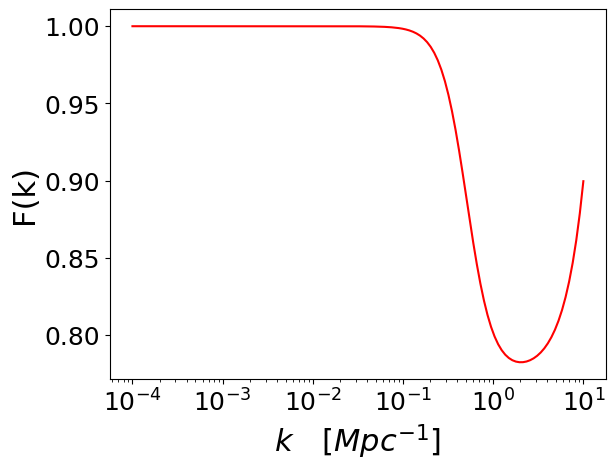

In [12]:
pk2D_no_baryons = cosmo.get_nonlin_power()
baryons = ccl.BaryonsSchneider15(14.25, 0.5, 37.)
pk2D_with_baryons = baryons.include_baryonic_effects(cosmo, pk2D_no_baryons)

pk_nl = pk2D_no_baryons(k, a)
pk_nl_bar = pk2D_with_baryons(k, a)

# Plot ratio of NL power spectra with/without baryons
pk_nl = ccl.nonlin_matter_power(cosmo, k, a)
plt.plot(k, pk_nl_bar/pk_nl, 'r-')

plt.xscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize = 22)
plt.ylabel('F(k)',fontsize=22)

plt.show()

### Cosmologies with neutrinos
CCL supports equal and unequal neutrino mass cosmologies. We give some examples below of how to set them up and obtain power spectra for them. Note that for the emulator case, we only support equal-mass cases.

In [16]:
cosmo_nu_eq = ccl.Cosmology(Omega_c=0.27, Omega_b=0.05, h=0.67, sigma8=0.8, n_s=0.96,
                            m_nu=0.06, mass_split='equal') #sum of the neutrino masses = 0.06
cosmo_nu_uneq = ccl.Cosmology(Omega_c=0.27, Omega_b=0.05, h=0.67, sigma8=0.8, n_s=0.96,
                              m_nu=[0.02,0.03,0.04], mass_split='list') #sum of neutrino masses = 0.02 + 0.03 + 0.04

pk_nl_nu_eq = ccl.nonlin_matter_power(cosmo_nu_eq, k, a)
pk_nl_nu_uneq = ccl.nonlin_matter_power(cosmo_nu_uneq, k, a)

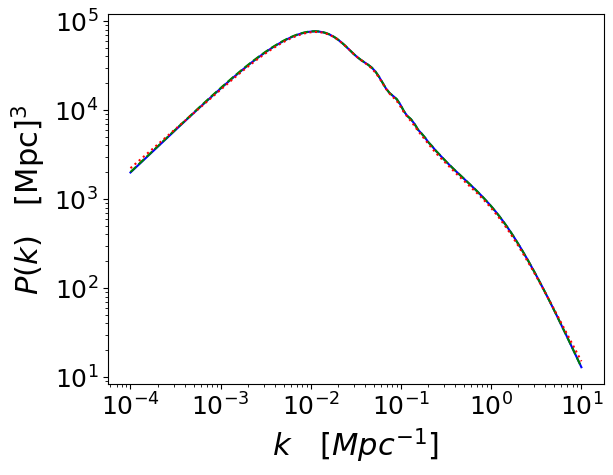

In [17]:
plt.plot(k, pk_nl_nu_eq, 'b-')
plt.plot(k, pk_nl_nu_uneq, 'g--')
plt.plot(k, pk_nl, 'r:')

plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize = 22)
plt.ylabel('$P(k)\quad[{\\rm Mpc}]^3$', fontsize=22)
plt.show()

## Example halo-model power spectrum calculation

We will now calculate the halo-model matter power spectrum. We begin by defining a set of cosmological parameters. 

In [18]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.8, n_s=0.96, 
                      Neff=0,m_nu=0,Omega_k=0,transfer_function='eisenstein_hu',
                      matter_power_spectrum='linear')

mass_def = ccl.halos.MassDef('vir', 'matter')
hmf = ccl.halos.MassFuncSheth99(mass_def=mass_def,mass_def_strict=False,use_delta_c_fit=True)
hbf = ccl.halos.HaloBiasSheth99(mass_def=mass_def,mass_def_strict=False)
cM = ccl.halos.ConcentrationDuffy08(mass_def=mass_def)
prf = ccl.halos.HaloProfileNFW(mass_def=mass_def, concentration=cM)
hmc = ccl.halos.HMCalculator(mass_function=hmf, halo_bias=hbf,mass_def=mass_def)

Note that this time we have specified some choices about the mass function and halo concentration we will use. Consistency of halo definition is enforced for each mass function or halo concentration. The halo-model power spectrum calculation currently makes the assumption that haloes have the 'virial' definition for their masses, so a mass function and halo concentration must be chosen that are consistent with this assumption.

### Calculate the matter power spectrum
Now, let's calculate various different types of power spectra.

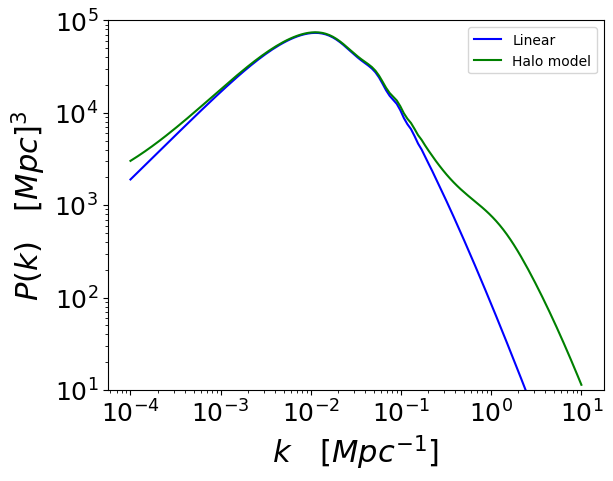

In [19]:
# Wavenumber
kmin=1e-4
kmax=1e1
nk=128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk) 

# Scale factor
a = 1. 

# Calculate different P(k)
pk_li = ccl.linear_matter_power(cosmo, k, a)
pk_hm = ccl.halos.halomod_power_spectrum(cosmo, hmc, k, a, prf)

plt.plot(k, pk_li, 'b-',  label='Linear')
plt.plot(k, pk_hm, 'g-',  label='Halo model')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r'$k\quad[Mpc^{-1}]$',fontsize=22)
plt.ylabel(r'$P(k)\quad[Mpc]^3$',fontsize=22)
plt.ylim([1e1,1e5])
plt.legend()
plt.show()

## Example of a modified gravity cosmology

First set some default cosmological parameters.

In [20]:
Omega_c = 0.25; Omega_b = 0.05; h = 0.7; A_s = 2.1e-9; n_s = 0.96; Neff = 3.046; m_nu = 0.

Set up some different mu_0 / Sigma_0 pairs.

In [21]:
mu_0 = [0.3, -0.3, 0.3, -0.3]
sigma_0 = [0.3, -0.3, -0.3, 0.3]

Set up the cosmology objects, including one where mu_0 = sigma_0 = 0, the GR case. We set the matter power spectrum type to linear the mu / Sigma parameterisation only supports linear scales.

In [22]:
from pyccl.modified_gravity import MuSigmaMG

cosmo_GR = ccl.Cosmology(Omega_c = Omega_c, Omega_b = Omega_b, h = h, A_s = A_s, n_s = n_s, 
                         Neff = Neff, m_nu = m_nu, matter_power_spectrum='linear')

cosmo_1 = ccl.Cosmology(Omega_c = Omega_c, Omega_b = Omega_b, h = h, A_s = A_s, n_s = n_s, 
                        Neff = Neff, m_nu = m_nu,
                        mg_parametrization=MuSigmaMG(mu_0 = mu_0[0], sigma_0 = sigma_0[0]),
                        matter_power_spectrum='linear')

cosmo_2 = ccl.Cosmology(Omega_c = Omega_c, Omega_b = Omega_b, h = h, A_s = A_s, n_s = n_s, 
                        Neff = Neff, m_nu = m_nu,
                        mg_parametrization=MuSigmaMG(mu_0 = mu_0[1], sigma_0 = sigma_0[1]), 
                        matter_power_spectrum='linear')


Compute the linear matter power spectrum (support for this parameterisation is limited to the linear regime). Again, the matter power spectrum is only affected by $\mu_0$, not $\Sigma_0$.

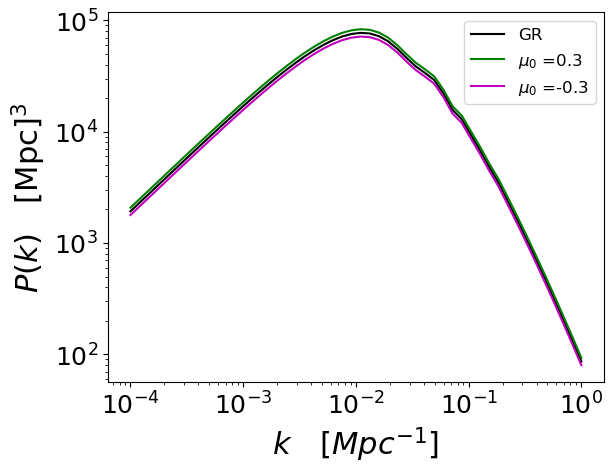

In [23]:
k = np.logspace(-4, 0) # 1 / Mpc units

Pk_GR = ccl.linear_matter_power(cosmo_GR, k, a=1.)
Pk_1 = ccl.linear_matter_power(cosmo_1, k, a=1.)
Pk_2 = ccl.linear_matter_power(cosmo_2, k, a=1.)

plt.loglog(k, Pk_GR, 'k', label='GR')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.loglog(k, Pk_1, 'g', label='$\mu_0$ ='+str(mu_0[0]))
plt.loglog(k, Pk_2, 'm', label='$\mu_0$ ='+str(mu_0[1]))
plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize = 22)
plt.ylabel('$P(k)\quad[{\\rm Mpc}]^3$', fontsize=22)
plt.legend(fontsize=12)
plt.show()